<a href="https://colab.research.google.com/github/Naimish240/CuriosityClassifier/blob/main/Curiosity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Semi-supervised labeling of Mars images shot by the Curiosity Rover**
***
By : [Naimish Mani B](https://www.linkedin.com/in/naimish-balaji-a6182b180/)
***

[Dataset 1](https://dominikschmidt.xyz/mars32k/):
A collection of 32k images shot from the Curiosity Rover at a resolution of 560*500. Used to train the AutoEncoder.

[Dataset 2](https://zenodo.org/record/1049137#.YKiaunUzbeT):
A collection of about 6.6k labeled images spanning across 25 classes at a resolution of roughly 256*256. Used to train the classification model. 

# **Introduction**

The Curiosity Rover stands strong on Mars, performing scientific experiments and sending images back on a regular basis. Broadly speaking, these images fall into 25 categories, including but not limited to "wheel", "drill", "drill hole", "turret", etc. Labelling all the images taken by the rover is a laborious task, though. From around 32k images shot by the rover, we only have labels for 6.6k of them (~20%). Given that about a fifth of the images have been labelled, we could attempt to train a Deep Neural Network for labelling the remaining images.


Unfortunately, since we have 25 image classes, that averages out to us having only about 250 images per class. This makes training a normal CNN for image classification very difficult, even through means of data augmentation.


Hence, we can try using semi-supervised learning methods to train a classifier. We leverage the original 32k images to train an AutoEncoder that attempts to learn a lower-dimensional representation of the images (aka latent vector). We subsequently make use of the lower-dimensional representation of the images to train a classifier. Given that we're dealing with vectors, we can use K-Nearest Neighbours and Support Vector Machines to build the classifier.

So, our training process is as follows:

1. Train a convolutional auto encoder on all 32k images.
2. Get latent vectors for all 6.6k labelled images.
3. Train a classifier on the 6.6k latent vectors.

**NOTE :**
This is only possible for this problem statement, because all our images are captured from the same source (Curiosity's camera). This procedure might not necessarily be valid for other datasets.

# **Auto Encoder**

## **Download and Extract Dataset**

In [ ]:
# Download Dataset 1
!gdown --id 1yeLkE1p5oeCqa5pA7tc0tI4eoyvjZc5X
!mkdir dataset_1

Downloading...
From: https://drive.google.com/uc?id=1yeLkE1p5oeCqa5pA7tc0tI4eoyvjZc5X
To: /content/mars32k.zip
3.42GB [00:55, 61.2MB/s]


In [ ]:
!unzip mars32k.zip -d dataset_1
!rm mars32k.zip

## **Pre Processing**

Now that we've downloaded the dataset, we next have to do standardise it (i.e., bring all images to a common base resolution). We do that by first cropping the images down to 500x500, and then bring the images down to a size of 64x64.

First, we go about getting the list of all images for the autoencoder

In [ ]:
import glob

ae_images = glob.glob('dataset_1/mars32k/*.jpg')
len(ae_images)

32368

Next, we load the images one by one, crop to 500x500, resize to 64x64 and store these final images in a list.

100%|██████████| 32368/32368 [04:13<00:00, 127.47it/s]


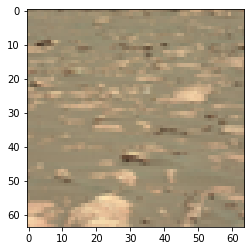

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tqdm

def image_processing_d1(path):
  img = PIL.Image.open(path)
  img = img.crop((30, 0, 530, 500))
  img = img.resize((64, 64))
  foo = np.array(img)
  return foo


AE_DATASET = []

with tqdm.tqdm(total=len(ae_images)) as t:
  for img in ae_images:
    i = image_processing_d1(img)
    #plt.imshow(i)
    #break
    AE_DATASET.append(i)
    t.update(1)

plt.imshow(AE_DATASET[0])

In [ ]:
AE_DATASET = np.array(AE_DATASET)
AE_DATASET.shape

(32368, 64, 64, 3)

In [ ]:
# Rescale, between 0 and 1
x = AE_DATASET / 255
# Verify if scaped properly
print(x.max(), x.min())
# Print shape for sanity sake
x.shape

1.0 0.0


(32368, 64, 64, 3)

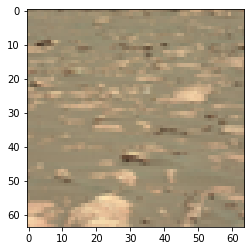

In [ ]:
# Function to display image from array
def img_show(img):
  # Clipping between 0 and 1 to prevent overflows
  plt.imshow(np.clip(img, 0, 1))

# Check if it works
img_show(x[0])

In [ ]:
# Free up memory because we're running low
del AE_DATASET
del ae_images

## **Building the Model**

In [ ]:
from tensorflow import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Reshape, InputLayer, Input
from keras.layers import Conv2D, UpSampling2D, MaxPooling2D

In [ ]:
# Memory cleanup, when re-running training code
del encoder, decoder, autoencoder, inp, code, reconstruction, history

In [ ]:
encoder = Sequential()

encoder.add(InputLayer((64,64,3)))
encoder.add(Conv2D(filters = 198, kernel_size = (3, 3), activation='relu', padding='same'))
encoder.add(MaxPooling2D(pool_size = (2, 2), padding='same'))
encoder.add(Conv2D(filters = 256, kernel_size = (3, 3), activation='relu', padding='same'))
encoder.add(MaxPooling2D(pool_size = (2, 2), padding='same'))
encoder.add(Conv2D(filters = 196, kernel_size = (3, 3), activation='relu', padding='same'))
encoder.add(MaxPooling2D(pool_size = (2, 2), padding='same'))
encoder.add(Flatten())
encoder.add(Dense(2500, activation='relu'))
encoder.add(Dense(784, activation='relu'))
encoder.add(Dense(512, activation='relu'))
encoder.add(Dense(256, activation='relu'))

decoder = Sequential()

decoder.add(InputLayer((256)))
decoder.add(Dense(512, activation='relu'))
decoder.add(Dense(784, activation='relu'))
decoder.add(Dense(2500, activation='relu'))
decoder.add(Dense(12544, activation='relu'))
decoder.add(Reshape((8,8,196)))
decoder.add(Conv2D(196, (3, 3), activation='relu', padding='same'))
decoder.add(UpSampling2D((2, 2)))
decoder.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
decoder.add(UpSampling2D((2, 2)))
decoder.add(Conv2D(198, (3, 3), activation='relu', padding='same'))
decoder.add(UpSampling2D((2, 2)))
decoder.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

inp = Input((64,64,3))
code = encoder(inp)
reconstruction = decoder(code)

print(encoder.summary())
print(decoder.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 198)       5544      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 198)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 256)       456448    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 196)       451780    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 196)         0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

In [ ]:
autoencoder = Model(inp,reconstruction)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 256)               34770304  
_________________________________________________________________
sequential_1 (Sequential)    (None, 64, 64, 3)         35128339  
Total params: 69,898,643
Trainable params: 69,898,643
Non-trainable params: 0
_________________________________________________________________


## **Train the Model**

In [ ]:
# Compile
# Session keeps crashing, need to fix later
history = autoencoder.fit(
    x = x,
    y = x,
    epochs=150,
    batch_size=256
)

Epoch 1/150
127/127 [==============================] - 166s 973ms/step - loss: 0.0180
Epoch 2/150
127/127 [==============================] - 116s 914ms/step - loss: 0.0152
Epoch 3/150
127/127 [==============================] - 116s 913ms/step - loss: 0.0127
Epoch 4/150
127/127 [==============================] - 116s 915ms/step - loss: 0.0081
Epoch 5/150
127/127 [==============================] - 116s 915ms/step - loss: 0.0067
Epoch 6/150
127/127 [==============================] - 116s 916ms/step - loss: 0.0067
Epoch 7/150
127/127 [==============================] - 116s 915ms/step - loss: 0.0062
Epoch 8/150
127/127 [==============================] - 116s 915ms/step - loss: 0.0061
Epoch 9/150
127/127 [==============================] - 116s 916ms/step - loss: 0.0059
Epoch 10/150
127/127 [==============================] - 116s 916ms/step - loss: 0.0057
Epoch 11/150
127/127 [==============================] - 116s 914ms/step - loss: 0.0056
Epoch 12/150
127/127 [==============================

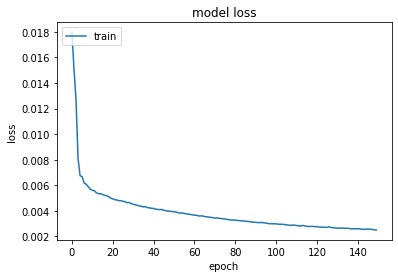

In [ ]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## **Visualising Reconstructions**


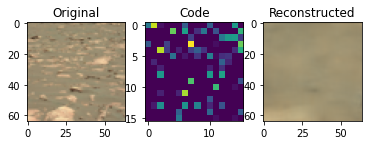

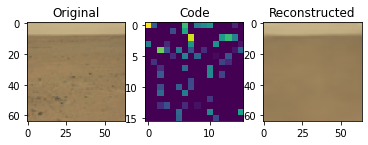

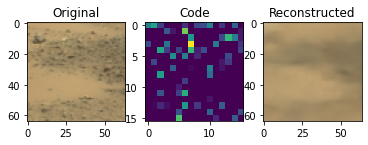

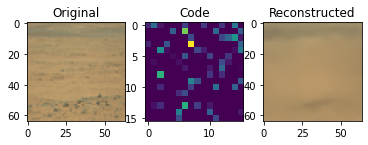

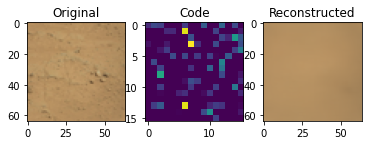

In [ ]:
# Reconstruction success
def visualize(img,encoder,decoder):
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    img_show(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape((16,16)))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    # reco = reco * 255
    # img_show(reco)
    plt.imshow(reco)
    plt.show()

for i in range(5):
    img = x[i]
    # print(img.shape)
    # print(img[None].shape)
    visualize(img,encoder,decoder)

From this, we can see that the model manages to get some pretty good reconstructions from the latent vector. The reconstructions are a bit blurry, which is expected of, of autoencoders.

## **t-SNE to visualise latent vectors**

In [ ]:
from sklearn.manifold import TSNE
x_viz = x[:1000]
x_compressed = encoder.predict(x_viz)
tsne = TSNE()
x_2D = tsne.fit_transform(x_compressed)
x_2D = (x_2D - x_2D.min()) / (x_2D.max() - x_2D.min())

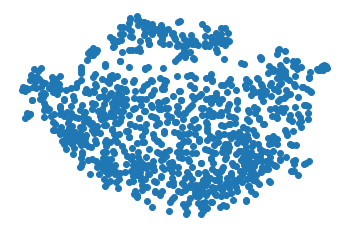

In [ ]:
plt.scatter(x_2D[:, 0], x_2D[:, 1])
plt.axis("off")
plt.show()

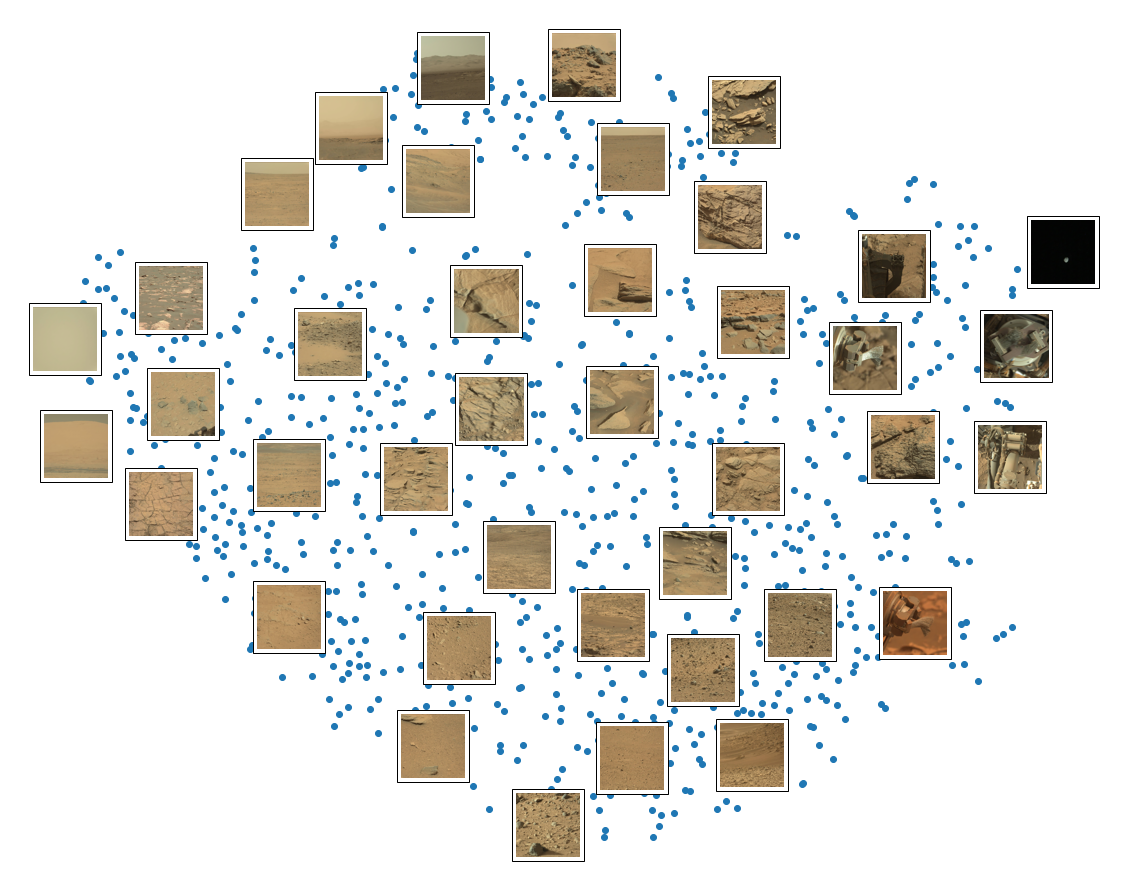

In [ ]:
# Adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
import matplotlib as mpl

plt.figure(figsize=(20, 16))
plt.scatter(x_2D[:, 0], x_2D[:, 1])
image_positions = np.array([[1., 1.]])
for index, position in enumerate(x_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.01: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_viz[index]),
            position)
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

From this, we can clearly see that there is good seperation between broad classes of images in the latent space. This implies that the autoencoder has probably learnt a good latent-representation mapping for the input images.

# **Classification**

## **Download and Extract Dataset**

In [ ]:
# Download Dataset 2
!wget https://zenodo.org/record/1049137/files/msl-images.zip
!mkdir dataset_2

--2021-09-04 14:25:48--  https://zenodo.org/record/1049137/files/msl-images.zip
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60635475 (58M) [application/octet-stream]
Saving to: ‘msl-images.zip’

msl-images.zip      100%[===================>]  57.83M  10.3MB/s    in 7.5s    

2021-09-04 14:25:57 (7.73 MB/s) - ‘msl-images.zip’ saved [60635475/60635475]



In [ ]:
!unzip msl-images.zip -d dataset_2
!rm -r msl-images.zip

## **Pre Processing**

In [ ]:
clustering_imgs = glob.glob('dataset_2/calibrated/*.JPG')
len(clustering_imgs)

6737

In [ ]:
!ls dataset_2

calibrated		      test-calibrated-shuffled.txt
msl_synset_words-indexed.txt  train-calibrated-shuffled.txt
README.txt		      val-calibrated-shuffled.txt


Next, we get the image - class mapping

In [ ]:
!cd dataset_2 && cat train-calibrated-shuffled.txt test-calibrated-shuffled.txt val-calibrated-shuffled.txt > all.txt

In [ ]:
fh = open('dataset_2/all.txt', 'r')
l = fh.readlines()
print(len(l))

6691


In [ ]:
path_class = {}
for line in l:
  k, v = line.split()
  path_class["dataset_2/"+k] = v
len(path_class)

6691

Now, we resize all images to 64*64, to make it compatable with the encoder from the autoencoder.

100%|██████████| 6737/6737 [00:11<00:00, 599.09it/s]


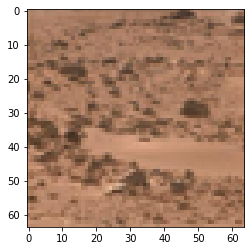

In [ ]:
def image_processing_d2(path):
  img = PIL.Image.open(path)
  img = img.resize((64, 64))
  foo = np.array(img)
  return foo

clustering_dataset = {}

with tqdm.tqdm(total=len(clustering_imgs)) as t:
  for img in clustering_imgs:
    i = image_processing_d2(img)
    clustering_dataset[img] = i
    t.update(1)

plt.imshow(clustering_dataset[clustering_imgs[0]])

In [ ]:
removed = 0
dataset = {}
for img in clustering_dataset.keys():
  if clustering_dataset[img].shape == (64,64):
    removed += 1
  else:
    dataset[img] = clustering_dataset[img]
print(f"Removed {removed} images")

Removed 183 images


In [ ]:
x = []
y = []

for path in dataset.keys():
  # ignore images without proper label
  try:
    y.append(path_class[path])
    x.append(dataset[path])
  except:
    continue

x = np.array(x)
print(x.shape)
print(len(y))

(6519, 64, 64, 3)
6519


In [ ]:
# Rescale, between 0 and 1
x = x / 255
# Verify if scaped properly
print(x.max(), x.min())
# Print shape for sanity sake
x.shape

1.0 0.0


(6519, 64, 64, 3)

## **Get Vectors for all Images**

In [ ]:
vectors = []

for img in tqdm.tqdm(x):
  vector = encoder.predict(img[None])[0]
  vectors.append(vector)

print()
print(len(vectors))
len(vectors[0])

100%|██████████| 6519/6519 [06:20<00:00, 17.12it/s]


6519


256

## **Classification Algorithms**

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(vectors, y, random_state = 0)

### **K Nearest Neighbours**

We can see that the KNN algorithm has an accuracy of around 92%, which implies that the autoencoder has done a good job at seperation in the latent space.

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 7).fit(X_train, y_train)

accuracy = knn.score(X_test, y_test)
print(accuracy)

0.9208588957055215


### **SVM**

We can see that using a SVM gives us an accuracy of 94.5%, clearly demonstrating that the autoencoder has done a good job at dimensionality reduction.

In [ ]:
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, y_train)
svm_predictions = svm_model_linear.predict(X_test)

accuracy = svm_model_linear.score(X_test, y_test)
print(accuracy)

0.945398773006135


### **Naive Bayes**

This classifier only gives us an accuracy of 37.8%, which is to be expected, given what was observed on the latent space after t-SNE.

In [ ]:
gnb = GaussianNB().fit(X_train, y_train)
gnb_predictions = gnb.predict(X_test)

accuracy = gnb.score(X_test, y_test)
print(accuracy)

0.37852760736196317


# **Conclusion**

From this, we can conclude that the semi-supervised technique can be leveraged to train classifiers when there's a large corpus of unlabelled images and a small subset of labelled images.